<a href="https://colab.research.google.com/github/Lee-F-Evans/qualtrix_survey_debotter/blob/main/de_botter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A hopefully useful de-botter

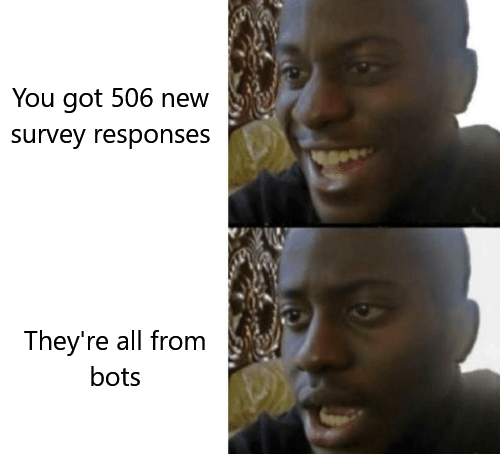

# 0 How To Use

1.   Set select which tests you would like to run by putting `True` next to the variable in "1.1 Test Selection and Limits"
2.   Set your variable parameters at 1.1 Test Selection and Limits, or leave as default and run all. Here is what each variable does:
  *   **captcha_limit:** A value of 1.0 is most likely a human and a value of 0.0 is most likely a bot. Everything below this value gets removed. Some bots are good at this and some humans are not, so play around with this value. To read more check out [reCAPTCHA](https://developers.google.com/recaptcha/docs/v3).
  * **fraud_limit:** This is a Qualtrics generated metric. Idk how good it works. A value of 0 is likely a human and [Qualtrics](https://www.qualtrics.com/support/survey-platform/survey-module/survey-checker/fraud-detection/) suggests a value above 30 is a bot. 30 seems to capture a lot of humans, so you might want to use a higher number like 40. The worst score is 130.
  * **incomplete_limit:** This value is the percent that the survey response was complete by total questions answered. Only responses over this value are included in the final .csv. Choose a value between 0 and 100.
  * **attention_question:** put your attention question between the apostrophes ''. It would be best to pull this from the excel file to ensure formatting is the same.
  * **attention_answer:** Put your answer to the attention check question between the apostrophes. This is used to filter out all responses that didnt select the correct answer. It would be best to pull this from the excel file to ensure formatting is the same.
3. At the top of the page under the 'Runtime' dropdown, and select 'Restart and run all'
4. After a minute or so a popup will appear to accept downloads. Press allow and your files will download.
5. Scroll down to section 4 and view the results graphs.  





This is likely what qualtrics is doing to remove bots with their bot removal tool. Source: https://www.qualtrics.com/support/survey-platform/survey-module/survey-checker/fraud-detection/

# 1 - Setup

In [1]:
#@title ## 1.0 Imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import time
from google.colab import files

In [2]:
#@title ## 1.1 Test Selection and Limits
# Test selection. Write True or False to use the test or not.
DUPLICATE_RESPONSE = False

INCOMPLETE_TEST = False
DUPLICATE_TEST = False
CAPTCHA_TEST = False
ATTENTION_TEST = True
FRAUD_TEST = False


#### Variables ####
#You need to set these variables for attention check
short_answer_q = ['Q35', 'Q36']

attention_question = 'Q24_31'
attention_answer = '1=Never'

#You can change these to adjust the filtering
#value between 0.0 and 1.0. The higher the number the more likely your are to only get humans, but the more likely you remove a person who behaves like a bot.
#Under graphs you can see what the distribution of this score is like within your responses. Default = 0.8
captcha_limit = 0.8

#value between 0 and 130. The lower the number the more likely your are to only get humans, but the more likely you remove a person who behaves like a bot.
#This is a metric that is created by Qualtrics. 
#If you use the Debot feature on their website, this is likely whats being used. Under graphs you can see what the distribution of this score is like within your responses.
#Default = 40
fraud_limit = 40

#Value between 100 and 0 representing the surveys percent complete. If you left some questions optional the percent complete could be less than 100. maybe use something around 90-100%? 
incomplete_limit = 95




In [3]:
#@title ## 1.2 File Upload
# upload data
uploaded = files.upload()
print(uploaded.keys)
df = pd.read_csv(list(uploaded.keys())[0])

Saving Text Thesis Survey Official Version_March 4, 2023_15.32.csv to Text Thesis Survey Official Version_March 4, 2023_15.32 (1).csv
<built-in method keys of dict object at 0x7f220143cd40>


In [4]:
#@title ## 1.3 Pre-Processing and Response Count

#Strip the metadata from the first two rows to throw back in later.
meta_data = df.iloc[:2]
#Remove first row. These are the questions text.
df = df.iloc[1:]
#Remove second row. This is unused meta data from qualtrix or whatever 
df = df.iloc[1:]

print(f'Total survey responses is: {len(df.index)}')

Total survey responses is: 1210


# 2 Flag responses and count
### Each test will have a before count and after count to show the amount removed.
### df1 will have 5 new columns to display `True` if a response failed each of the 5 tests below.


In [5]:
#@title
df1 = df

In [6]:
#@title ## 2.1 Incomplete Response Test
df1.Progress = pd.to_numeric(df1.Progress)
df1['incomplete'] = np.where(df1['Progress'] < incomplete_limit, True, False)
incomplete = df1.incomplete.value_counts()
incomplete

False    1055
True      155
Name: incomplete, dtype: int64

In [7]:
#@title ## 2.2 Duplicate Session ID Test
df1['duplicate'] = np.where(df1['Q_RelevantIDDuplicate'] == 'true', True, False)
duplicate = df1.duplicate.value_counts()
duplicate

False    1168
True       42
Name: duplicate, dtype: int64

In [8]:
#@title ## 2.3 Captcha Check
df1.Q_RecaptchaScore = pd.to_numeric(df1.Q_RecaptchaScore)
df1['captcha'] = np.where(df1['Q_RecaptchaScore'] < captcha_limit, True, False)
captcha = df1.captcha.value_counts()
captcha

False    894
True     316
Name: captcha, dtype: int64

In [9]:
#@title ## 2.4 Qualtrics Fraud Check
df1.Q_RelevantIDFraudScore = pd.to_numeric(df1.Q_RelevantIDFraudScore)
df1['fraudscore'] = np.where(df1['Q_RelevantIDFraudScore'] > fraud_limit, True, False)
fraudscore = df1.fraudscore.value_counts()
fraudscore

False    1078
True      132
Name: fraudscore, dtype: int64

In [10]:
#@title ## 2.5 Failed Attention Check Test
df1['attention'] = np.where(df1[attention_question] != attention_answer, True, False)
attention = df1.attention.value_counts()
attention

False    818
True     392
Name: attention, dtype: int64

# 3 Filter Data

In [ ]:
# Same Response
# check if response unique. -> if not, remove all -> if is unique skip
before = len(df1.index)

if DUPLICATE_RESPONSE:
  df1 = df1.drop_duplicates(subset = short_answer_q[1] ,keep=False)
else:
  print("This test was not run. Enable at the start of the script to run.")

after = len(df1.index)            
print(f"Number of responses before: {before} \nNumber of responses after: {after} \nTotal removed for failed attention check: {before - after} ")

In [11]:
#@title ## 3.1 Attention Check Test
before = len(df1.index)

if ATTENTION_TEST:
  #saves all the removed responses as a csv
  df_trash = df1[(df1.attention) == True]
  df_trash.to_csv("removed_failed_attention_check.csv")
  files.download("removed_failed_attention_check.csv")

  #File needs time to download
  time.sleep(7)

  #removes all the failed attention check responses
  df1 = df1[(df1.attention) != True]
else:
  print("This test was not run. Enable at the start of the script to run.")

after = len(df1.index)            
print(f"Number of responses before: {before} \nNumber of responses after: {after} \nTotal removed for failed attention check: {before - after} ")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Number of responses before: 1210 
Number of responses after: 818 
Total removed for failed attention check: 392 


In [12]:
#@title ## 3.2 Incomplete Response Test
before = len(df1.index)

if INCOMPLETE_TEST:
  #df is only submissions over 95% complete
  df_trash = df1[(df1.incomplete) == True]
  df_trash.to_csv(f"removed_incomplete_responses_below_{incomplete_limit}.csv")
  files.download(f"removed_incomplete_responses_below_{incomplete_limit}.csv")

  #File needs time to download
  time.sleep(7)

  df1 = df1[(df1.incomplete) != True]
else:
  print("This test was not run. Enable at the start of the script to run.")


after = len(df1.index)
print(f"Number of responses before: {before} \nNumber of responses after: {after} \nTotal removed for below 95% surveycompletion: {before - after} ")

This test was not run. Enable at the start of the script to run.
Number of responses before: 818 
Number of responses after: 818 
Total removed for below 95% surveycompletion: 0 


In [13]:
#@title ## 3.3 Captcha Test
# This is to view the distribution of captcha scores in the data before anything gets deleted.

df.Q_RecaptchaScore = pd.to_numeric(df.Q_RecaptchaScore)
print(len(df.index))
df.Q_RecaptchaScore.value_counts(bins=5)

1210


(0.8, 1.0]       728
(0.6, 0.8]       109
(-0.002, 0.2]     93
(0.2, 0.4]        59
(0.4, 0.6]        55
Name: Q_RecaptchaScore, dtype: int64

In [14]:
#@title
# Captcha filter
before = len(df1.index)

if CAPTCHA_TEST:
  #Save all the removed responses in a csv
  df_trash = df1[(df1.captcha) == True]
  df_trash.to_csv(f"removed_captcha_below_{captcha_limit}.csv")
  files.download(f"removed_captcha_below_{captcha_limit}.csv")

  #File needs time to download
  time.sleep(7)

  #Save only responses over 80% captcha score
  df1 = df1[(df1.captcha) != True]
else:
  print("This test was not run. Enable at the start of the script to run.")

after = len(df1.index)
print(f"Number of responses before: {before} \nNumber of responses after: {after} \nTotal removed for a captcha score below 80%: {before - after} ")

This test was not run. Enable at the start of the script to run.
Number of responses before: 818 
Number of responses after: 818 
Total removed for a captcha score below 80%: 0 


In [15]:
#@title ## 3.4 Duplicate Test
before = len(df1.index)

if DUPLICATE_TEST:
  #Save all the removed responses in a csv
  df_trash = df1[(df1.duplicate) == True]
  df_trash.to_csv(r"removed_duplicates.csv")
  files.download("removed_duplicates.csv")

  #File needs time to download
  time.sleep(7)

  #Save only responses over 80% captcha score
  df1 = df1[(df1.duplicate) != True]
else:
  print("This test was not run. Enable at the start of the script to run.")

after = len(df1.index)
print(f"Number of responses before: {before} \nNumber of responses after: {after} \nTotal removed for a duplicate ID: {before - after} ")

This test was not run. Enable at the start of the script to run.
Number of responses before: 818 
Number of responses after: 818 
Total removed for a duplicate ID: 0 


In [16]:
#@title ## 3.5 Qualtrics Fraud Test

before = len(df1.index)

if FRAUD_TEST:
  #Save all the removed responses in a csv
  df_trash = df1[(df1.fraudscore) == True]
  df_trash.to_csv(f"removed_fraud_score_above_{fraud_limit}.csv")
  files.download(f"removed_fraud_score_above_{fraud_limit}.csv")

  #File needs time to download
  time.sleep(7)

  #Save only responses under 40 fraud score score
  df1 = df1[(df1.fraudscore) != True]
else:
  print("This test was not run. Enable at the start of the script to run.")

after = len(df1.index)
print(f"Number of responses before: {before} \nNumber of responses after: {after} \nTotal removed for above 40 on qualtrics fraud score.. : {before - after} ")

This test was not run. Enable at the start of the script to run.
Number of responses before: 818 
Number of responses after: 818 
Total removed for above 40 on qualtrics fraud score.. : 0 


# 4 - Visualize Data

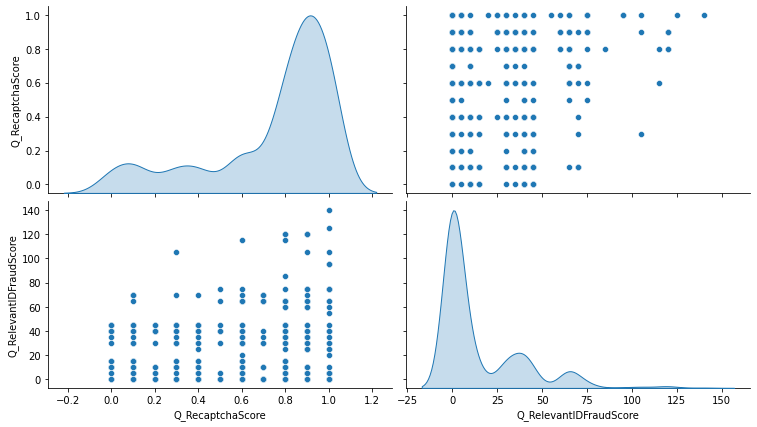

In [17]:
#@title
# without regression
sns.pairplot(df[['Q_RecaptchaScore','Q_RelevantIDFraudScore']], diag_kind="kde", height=3, aspect=16/9)

plt.show()

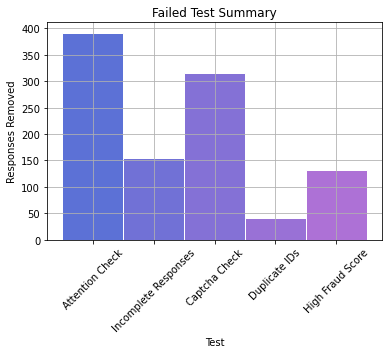

In [20]:
#@title
#Each test graphed
labels = ['Attention Check', 'Incomplete Responses', 'Captcha Check', 'Duplicate IDs', 'High Fraud Score' ]
height = [attention[1], incomplete[1], captcha[1], duplicate[1], fraudscore[1],]

# print(height)
plt.bar(labels, height= height, color=[(0.2,0.3,0.8,.8),(0.3,0.3,0.8,.8),(0.4,0.3,0.8,.8),(0.5,0.3,0.8,.8),(0.6,0.3,0.8,.8)], edgecolor='white', width=1)

#add values to the top of the graphs
# for i in range(len(labels)):
#     plt.text(i, height[i], height[i], ha = 'center', color = 'white', Bbox = dict(facecolor = 'blue', alpha =.8))

plt.xticks(labels, rotation=45)
plt.ylabel("Responses Removed")
plt.xlabel("Test")
plt.title("Failed Test Summary")

plt.grid(True)
plt.show()

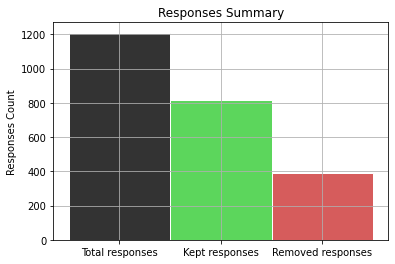

In [19]:
#@title
# pd.options.mode.chained_assignment = None  # default='warn'

total_res = len(df)
removed_res = len(df1)
labels = ["Total responses", "Kept responses","Removed responses"]

height = [total_res, removed_res, total_res - removed_res]
plt.bar(labels, height= height, edgecolor='white', width=1, color = [(0.2,0.2,0.2,1), (0.2,0.8,0.2,.8), (.8,0.2,0.2,.8)])

#add values to the top of the graphs
# for i in range(len(labels)):
#     plt.text(i, height[i], height[i], ha = 'center', color = 'white', Bbox = dict(facecolor = 'blue', alpha =.8))

plt.ylabel("Responses Count")
plt.title("Responses Summary")

plt.grid(True)

# 5 Save remaining data

In [21]:
#@title
# save the remaining .csv file
df1.to_csv('debotted_data.csv')

# download all data
files.download('debotted_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>